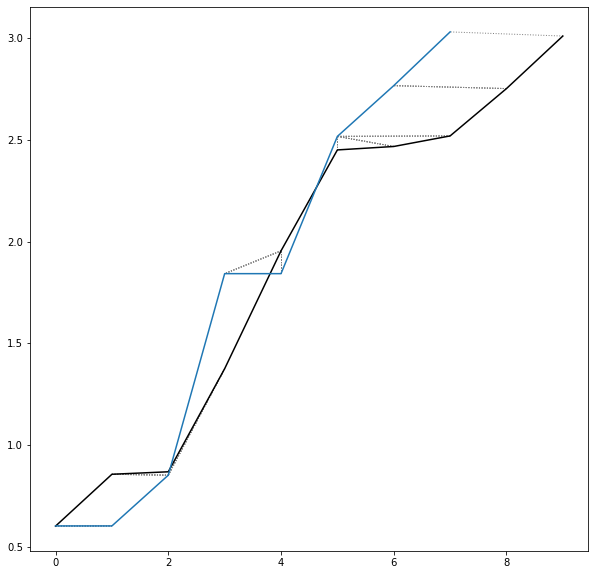

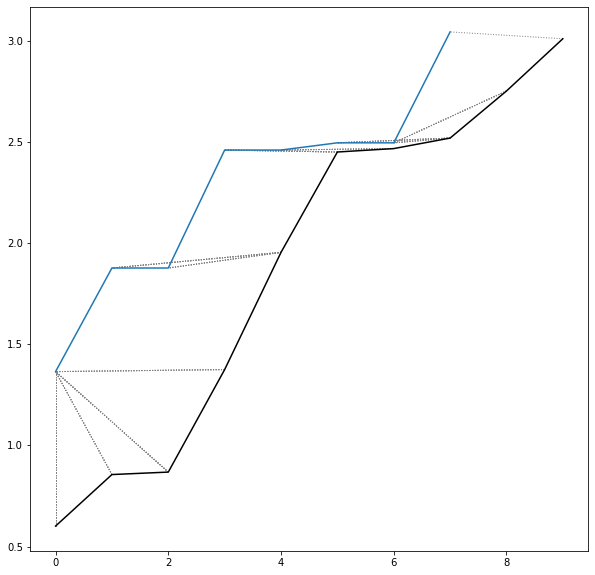

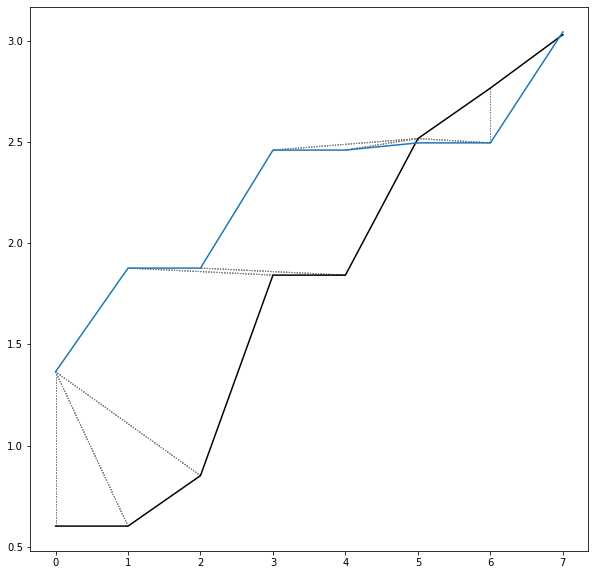

[0.06341304640195786, 0.13547633781963736, 0.16799779247670305]


In [32]:
# https://dynamictimewarping.github.io/python/
from dtw import *
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

np.random.seed(1234)
x = np.random.uniform(0,np.pi,10)
x1 = x + np.random.normal(0,0.05,10)
x2 = x + np.random.normal(0,0.05,10)

np.random.shuffle(x)
np.random.shuffle(x1)
np.random.shuffle(x2)

x1 = np.random.choice(x1, len(x1)-2)
x2 = np.random.choice(x2, len(x2)-2)

x.sort()
x1.sort()
x2.sort()


alignment1 = dtw(x, x1, keep_internals=True)
p1 = alignment1.plot(type="twoway")
alignment2 = dtw(x, x2, keep_internals=True)
p2 = alignment2.plot(type="twoway")
alignment3 = dtw(x1, x2, keep_internals=True)
p3 = alignment3.plot(type="twoway")



print([alignment1.normalizedDistance, alignment2.normalizedDistance, alignment3.normalizedDistance])
